In [1]:
# HPC
import numpy as np
import xarray as xr
from scipy.interpolate import interp1d

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator, NullFormatter
from matplotlib.colors import SymLogNorm
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import colors, ticker
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm as mplcm
from matplotlib.colors import TwoSlopeNorm

import cmocean
import cmocean.cm as cmo

# Paths and stuff
import os
import sys

import re
import warnings
warnings.filterwarnings("ignore")

sys.path.append('/home/shreyas/pySICOPOLIS/src')
from pySICOPOLIS import *

In [2]:
def plot_normal_new(
    x, y, data, *,
    cmap='RdBu_r', nbins=256,
    vmin=-10, vmax=10, center=0.0,
    cbar_ticks=None, cbar_label=None,
    fig=None, ax=None
):
    if ax is None:
        fig, ax = plt.subplots()

    # same norm for all panels
    norm = TwoSlopeNorm(vmin=vmin, vcenter=center, vmax=vmax)

    # same level boundaries for all panels
    levels = np.linspace(vmin, vmax, nbins)

    im = ax.contourf(x, y, data,
                     levels=levels, cmap=cmap, norm=norm,
                     extend='both')

    # colorbar with the SAME boundaries (fixes spacing)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb = fig.colorbar(im, cax=cax,
                      boundaries=levels, spacing='proportional',
                      extend='both')
    if cbar_ticks is not None:
        cb.set_ticks(cbar_ticks)
        cb.set_ticklabels([f'{t:g}' for t in cbar_ticks])
    if cbar_label:
        cb.set_label(cbar_label)

    return ax

def extract_costs_from_file(filepath, iter_final):
    cost_list = []
    misfit_cost_list = []
    reg_cost_list = []

    pattern = re.compile(
        r"Iteration\s+\d+:\s+Cost\s+=\s+([0-9.]+),\s+Misfit Cost\s+=\s+([0-9.]+),\s+Regularization Cost\s+=\s+([0-9.]+)"
    )

    with open(filepath, 'r') as file:
        for line in file:
            match = pattern.search(line)
            if match:
                cost, misfit, reg = map(float, match.groups())
                cost_list.append(cost)
                misfit_cost_list.append(misfit)
                reg_cost_list.append(reg)

    return cost_list[:iter_final + 1], misfit_cost_list[:iter_final + 1], reg_cost_list[:iter_final + 1]

In [3]:
modelPath = '/home/shreyas/update_to_develop_sicopolis/sicopolis_spinups/sico_out/'
dataPath = '/scratch2/shreyas/GrIS_paleo_data/'

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data_40_orig = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms_orig.nc")
ds_surfvel_data_40km = xr.open_dataset(dataPath + 'surfvel_data_40kms.nc')
ds_surfvel_model_40km_nottuned = xr.open_dataset(modelPath + 'grl40_bm5_paleo17a_nudged_CT4_BH0_m21ka_pkp/grl40_bm5_paleo17a_nudged_CT4_BH0_m21ka_pkp0007.nc')
ds_surfvel_model_40km_tuned = xr.open_dataset("/home/shreyas/update_to_develop_sicopolis/sicopolis_optim_SVC_3point5_50_new_pickup_2/sico_out/N_grl40_bm5_paleo17a_nudged_CT4_BH0_SVC_m21ka_pkp/0007.nc")

ds_state_0 = xr.open_dataset("/scratch2/shreyas/optim_SVC_3point5_50_new/inexact_gn_hessian_cg/state_GNHessCG_iter_0.nc")
ds_state = xr.open_dataset("/scratch2/shreyas/optim_SVC_3point5_50_new_pickup_2/inexact_gn_hessian_cg/state_GNHessCG_iter_25.nc")

prior_samples_cost = np.loadtxt("/scratch2/shreyas/thesis_results/chapter_6/prior_samples/sample_cost.txt", skiprows = 1)[:1000]
posterior_samples_cost = np.loadtxt("/scratch2/shreyas/thesis_results/chapter_6/posterior_samples/sample_cost.txt", skiprows = 1)[:1000]

ds_mean_prior = xr.open_dataset("/scratch2/shreyas/thesis_results/chapter_6/mean_samples_prior.nc")
ds_mean_posterior = xr.open_dataset("/scratch2/shreyas/thesis_results/chapter_6/mean_samples_posterior.nc")
ds_std_prior = xr.open_dataset("/scratch2/shreyas/thesis_results/chapter_6/std_samples_prior.nc")
ds_std_posterior = xr.open_dataset("/scratch2/shreyas/thesis_results/chapter_6/std_samples_posterior.nc")

ds_sample_prior_1 = xr.open_dataset("/scratch2/shreyas/thesis_results/chapter_6/prior_samples/prior_sample_1.nc")
ds_sample_prior_2 = xr.open_dataset("/scratch2/shreyas/thesis_results/chapter_6/prior_samples/prior_sample_2.nc")
ds_sample_posterior_1 = xr.open_dataset("/scratch2/shreyas/thesis_results/chapter_6/posterior_samples/posterior_sample_1.nc")
ds_sample_posterior_2 = xr.open_dataset("/scratch2/shreyas/thesis_results/chapter_6/posterior_samples/posterior_sample_2.nc")

ds_prior_X = xr.open_dataset("/scratch2/shreyas/optim_SVC_3point5_50_new/prior_X.nc")

U_misfit_sa = np.load("/scratch2/shreyas/REVD_3point5_50_new_pickup_2/REVD_single_approx/U_misfit_600.npy")
Lambda_misfit_sa = np.load("/scratch2/shreyas/REVD_3point5_50_new_pickup_2/REVD_single_approx/Lambda_misfit_600.npy")

H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

vs_orig_data = ds_surfvel_data_40km["vs_orig"].data
vs_data = ds_surfvel_data_40km["vs"].data
vx_data = ds_surfvel_data_40km["vx"].data
vy_data = ds_surfvel_data_40km["vy"].data

# Cost function is the sum of 2 ratios, each of which is 1/2*(non-zero data), so total should be 1.0*(non-zero data)
one_sigma_threshold = np.sum(vs_data != 0.0)

vs_model_nottuned = (ds_surfvel_model_40km_nottuned['vx_s_g'].data**2 + ds_surfvel_model_40km_nottuned['vy_s_g'].data**2)**0.5
vx_model_nottuned = ds_surfvel_model_40km_nottuned['vx_s_g'].data
vy_model_nottuned = ds_surfvel_model_40km_nottuned['vy_s_g'].data

vs_model_tuned = (ds_surfvel_model_40km_tuned['vx_s_g'].data**2 + ds_surfvel_model_40km_tuned['vy_s_g'].data**2)**0.5
vx_model_tuned = ds_surfvel_model_40km_tuned['vx_s_g'].data
vy_model_tuned = ds_surfvel_model_40km_tuned['vy_s_g'].data

mask_land_nottuned = ds_surfvel_model_40km_nottuned["mask"].data.copy()
mask_land_nottuned[mask_land_nottuned == 0] = -1
mask_land_nottuned[mask_land_nottuned == 1] = -1
mask_land_nottuned[mask_land_nottuned == 2] = 1
mask_land_nottuned[mask_land_nottuned == 3] = 1

mask_ice_nottuned = ds_surfvel_model_40km_nottuned["mask"].data.copy()
mask_ice_nottuned[mask_ice_nottuned == 0] = -1
mask_ice_nottuned[mask_ice_nottuned == 3] = -1
mask_ice_nottuned[mask_ice_nottuned == 1] = 1
mask_ice_nottuned[mask_ice_nottuned == 2] = 1

mask_land_tuned = ds_surfvel_model_40km_tuned["mask"].data.copy()
mask_land_tuned[mask_land_tuned == 0] = -1
mask_land_tuned[mask_land_tuned == 1] = -1
mask_land_tuned[mask_land_tuned == 2] = 1
mask_land_tuned[mask_land_tuned == 3] = 1

mask_ice_tuned = ds_surfvel_model_40km_tuned["mask"].data.copy()
mask_ice_tuned[mask_ice_tuned == 0] = -1
mask_ice_tuned[mask_ice_tuned == 3] = -1
mask_ice_tuned[mask_ice_tuned == 1] = 1
mask_ice_tuned[mask_ice_tuned == 2] = 1

vs_model_nottuned_nan = vs_model_nottuned.copy()
vs_model_nottuned_nan[vs_model_nottuned_nan == 0.0] = np.nan
vs_model_tuned_nan = vs_model_tuned.copy()
vs_model_tuned_nan[vs_model_tuned_nan == 0.0] = np.nan
vs_data_nan = vs_data.copy()
vs_data_nan[vs_data_nan == 0.0] = np.nan

vx_model_nottuned_nan = vx_model_nottuned.copy()
vx_model_nottuned_nan[vx_model_nottuned_nan == 0.0] = np.nan
vx_model_tuned_nan = vx_model_tuned.copy()
vx_model_tuned_nan[vx_model_tuned_nan == 0.0] = np.nan
vx_data_nan = vx_data.copy()
vx_data_nan[vx_data_nan == 0.0] = np.nan

vy_model_nottuned_nan = vy_model_nottuned.copy()
vy_model_nottuned_nan[vy_model_nottuned_nan == 0.0] = np.nan
vy_model_tuned_nan = vy_model_tuned.copy()
vy_model_tuned_nan[vy_model_tuned_nan == 0.0] = np.nan
vy_data_nan = vy_data.copy()
vy_data_nan[vy_data_nan == 0.0] = np.nan

prior_samples_fc = prior_samples_cost[:, 1]
prior_samples_fc_data = prior_samples_cost[:, 2]
prior_samples_fc_reg = prior_samples_cost[:, 3]

posterior_samples_fc = posterior_samples_cost[:, 1]
posterior_samples_fc_data = posterior_samples_cost[:, 2]
posterior_samples_fc_reg = posterior_samples_cost[:, 3]

costs, misfits, regs = extract_costs_from_file(f"/scratch2/shreyas/optim_SVC_3point5_50_new/inexact_gn_hessian_cg/inexact_gn_hessian_cg.log", 1)
costs_p2, misfits_p2, regs_p2 = extract_costs_from_file(f"/scratch2/shreyas/optim_SVC_3point5_50_new_pickup_2/inexact_gn_hessian_cg/inexact_gn_hessian_cg.log", 25)

costs_final = np.r_[costs[0], costs_p2]
misfits_final = np.r_[misfits[0], misfits_p2]
regs_final = np.r_[regs[0], regs_p2]

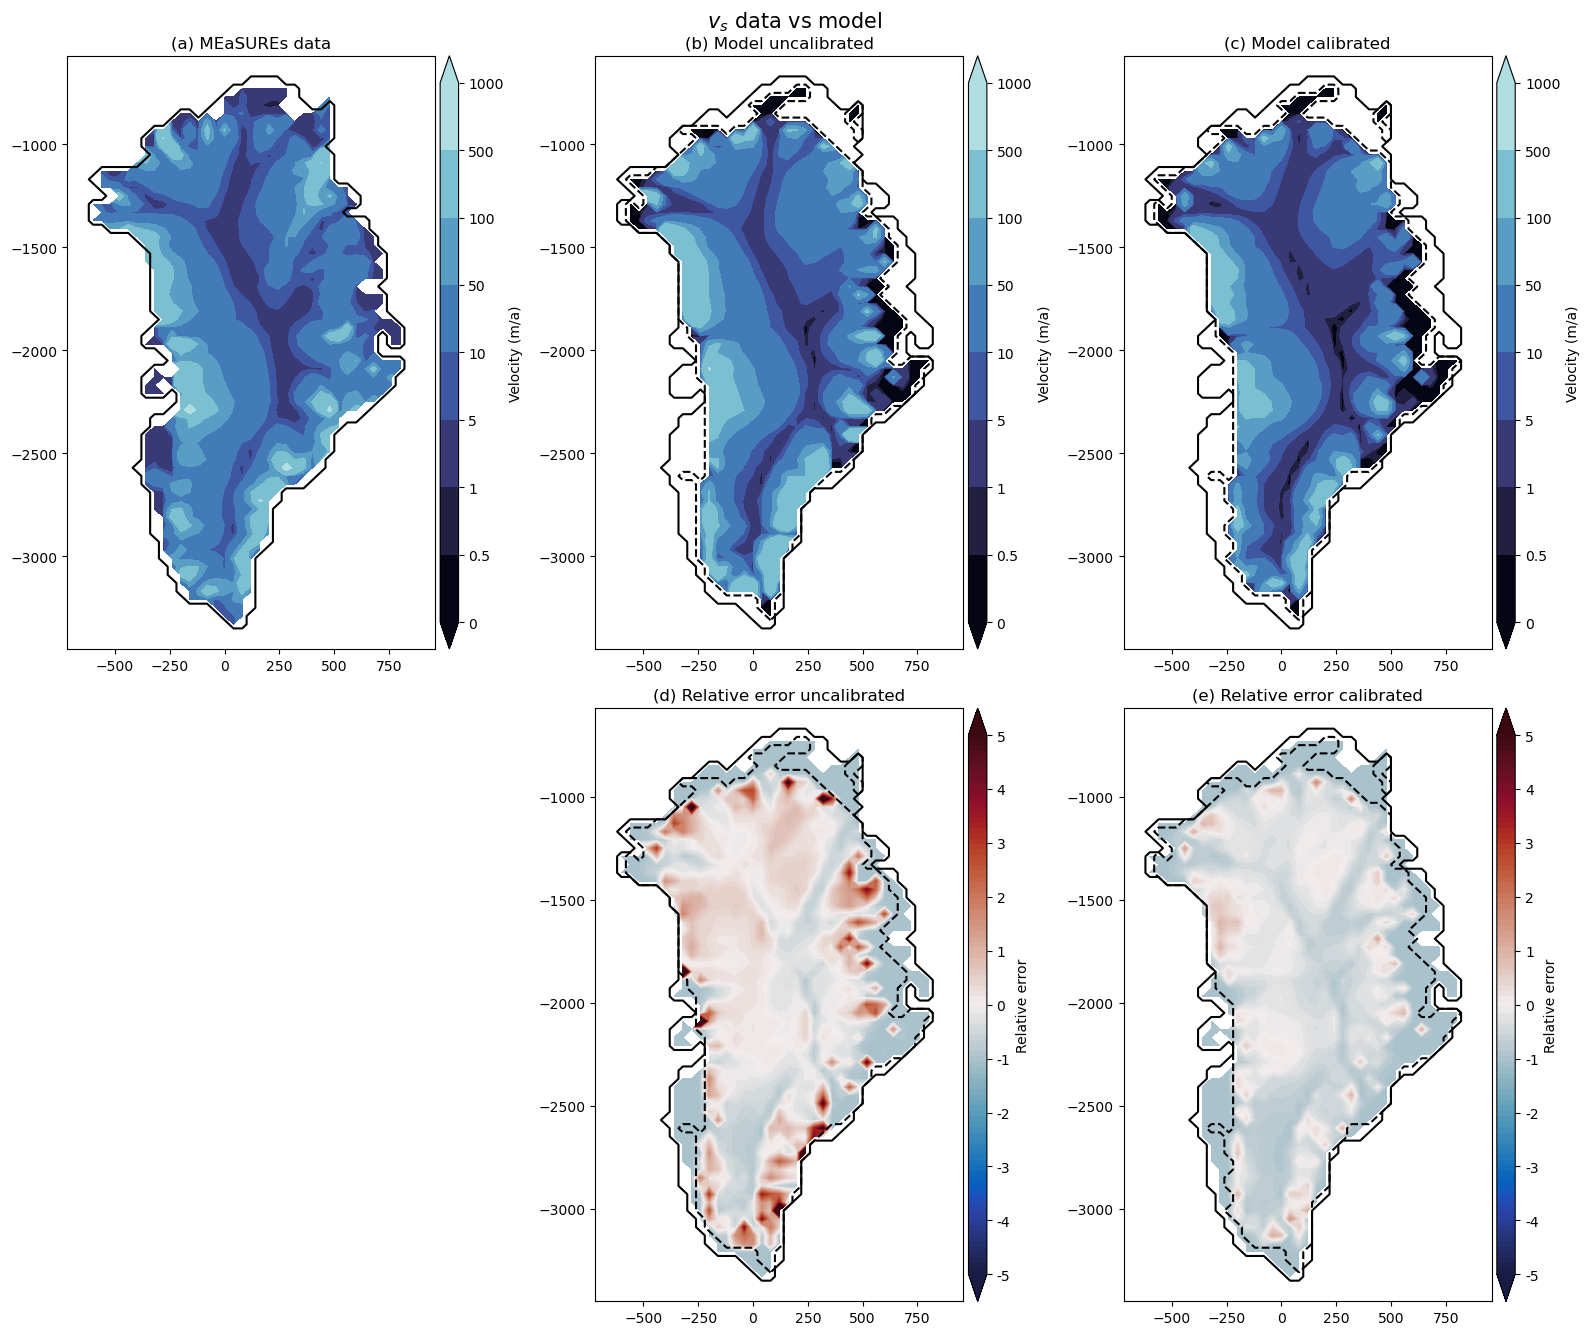

In [4]:
n_rows, n_cols = 2, 3
aspect_ratio = len(ds_surfvel_model_40km_nottuned['x'])/len(ds_surfvel_model_40km_nottuned['y'])
subplot_width = 4
subplot_height = subplot_width / aspect_ratio

plt.rcParams["figure.figsize"] = ((n_cols+1.0)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

# Define discrete bin edges
levels = [0.0, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]

# Use cmocean speed colormap
cmap = cmocean.cm.ice
n_intervals = len(levels) - 1
colors = [cmap(i / n_intervals) for i in range(n_intervals)]

# Plot discrete contourf on the existing ax
im = ax[0, 0].contourf(
    ds_surfvel_data_40km['x'],
    ds_surfvel_data_40km['y'],
    vs_data_nan,  # or vs_data field you're plotting
    levels=levels,
    colors=colors,
    extend='both'
)

ax[0, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")

# Attach a new colorbar to this ax
divider = make_axes_locatable(ax[0, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(im, cax=cax, ticks=levels, spacing='uniform')

# Label and format
cb.set_label("Velocity (m/a)")
cb.ax.set_yticklabels([f"{lev:g}" for lev in levels])
ax[0, 0].set_title("(a) MEaSUREs data")

# Plot discrete contourf on the existing ax
im = ax[0, 1].contourf(
    ds_surfvel_data_40km['x'],
    ds_surfvel_data_40km['y'],
    vs_model_nottuned_nan,  # or vs_data field you're plotting
    levels=levels,
    colors=colors,
    extend='both'
)

ax[0, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_nottuned, levels=[0], colors="black")
ax[0, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_nottuned, levels=[0], colors="black", linestyles = "dashed")

# Attach a new colorbar to this ax
divider = make_axes_locatable(ax[0, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(im, cax=cax, ticks=levels, spacing='uniform')

# Label and format
cb.set_label("Velocity (m/a)")
cb.ax.set_yticklabels([f"{lev:g}" for lev in levels])
ax[0, 1].set_title("(b) Model uncalibrated")

# Plot discrete contourf on the existing ax
im = ax[0, 2].contourf(
    ds_surfvel_data_40km['x'],
    ds_surfvel_data_40km['y'],
    vs_model_tuned_nan,  # or vs_data field you're plotting
    levels=levels,
    colors=colors,
    extend='both'
)

ax[0, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

# Attach a new colorbar to this ax
divider = make_axes_locatable(ax[0, 2])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(im, cax=cax, ticks=levels, spacing='uniform')

# Label and format
cb.set_label("Velocity (m/a)")
cb.ax.set_yticklabels([f"{lev:g}" for lev in levels])
ax[0, 2].set_title("(c) Model calibrated")

plot_normal_new(ds_surfvel_data_40km['x'], 
                         ds_surfvel_data_40km['y'], 
                         np.clip(vs_model_nottuned/vs_data - 1, -10, 10),
                         cmap = 'cmo.balance', nbins = 100, vmin = -5, vmax = 5,
                         fig = fig, ax = ax[1, 1],
                         cbar_label = "Relative error", cbar_ticks=[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_nottuned, levels=[0], colors="black")
ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_nottuned, levels=[0], colors="black", linestyles = "dashed")
ax[1, 1].set_title("(d) Relative error uncalibrated")

plot_normal_new(ds_surfvel_data_40km['x'], 
                         ds_surfvel_data_40km['y'], 
                         np.clip(vs_model_tuned/vs_data - 1, -10, 10),
                         cmap = 'cmo.balance', nbins = 100, vmin = -5, vmax = 5,
                         fig = fig, ax = ax[1, 2],
                         cbar_label = "Relative error", cbar_ticks=[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
ax[1, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[1, 2].set_title("(e) Relative error calibrated")

# field = np.clip(vs_model_nottuned/vs_data - 1, -10, 10)
# field[vs_data < 50.0] = np.nan

# plot_normal_new(ds_surfvel_data_40km['x'], 
#                          ds_surfvel_data_40km['y'], 
#                          field,
#                          cmap = 'cmo.balance', nbins = 100, vmin = -5, vmax = 5,
#                          fig = fig, ax = ax[2, 1],
#                          cbar_label = "Relative error", cbar_ticks=[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
# ax[2, 1].contour(ds_surfvel_data_40km['x'], 
#                  ds_surfvel_data_40km['y'],
#                  mask_land_nottuned, levels=[0], colors="black")
# ax[2, 1].contour(ds_surfvel_data_40km['x'], 
#                  ds_surfvel_data_40km['y'],
#                  mask_ice_nottuned, levels=[0], colors="black", linestyles = "dashed")
# ax[2, 1].set_title("(f) Relative error uncalibrated (for regions where $v_s^{data} >= 100.0 ma^{-1}$")

# field = np.clip(vs_model_tuned/vs_data - 1, -10, 10)
# field[vs_data < 50.0] = np.nan

# plot_normal_new(ds_surfvel_data_40km['x'], 
#                          ds_surfvel_data_40km['y'], 
#                          field,
#                          cmap = 'cmo.balance', nbins = 100, vmin = -5, vmax = 5,
#                          fig = fig, ax = ax[2, 2],
#                          cbar_label = "Relative error", cbar_ticks=[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
# ax[2, 2].contour(ds_surfvel_data_40km['x'], 
#                  ds_surfvel_data_40km['y'],
#                  mask_land_tuned, levels=[0], colors="black")
# ax[2, 2].contour(ds_surfvel_data_40km['x'], 
#                  ds_surfvel_data_40km['y'],
#                  mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
# ax[2, 2].set_title("(g) Relative error calibrated (for regions where $v_s^{data} >= 100.0 ma^{-1}$")

# Hide or remove the empty subplot
fig.delaxes(ax[1, 0])      # completely removes it
# OR
ax[1, 0].set_visible(False)  # keeps it in layout but hides borders/ticks

# # Hide or remove the empty subplot
# fig.delaxes(ax[2, 0])      # completely removes it
# # OR
# ax[2, 0].set_visible(False)  # keeps it in layout but hides borders/ticks

plt.suptitle("$v_s$ data vs model", fontsize=15)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_6/vs_data_model.png")

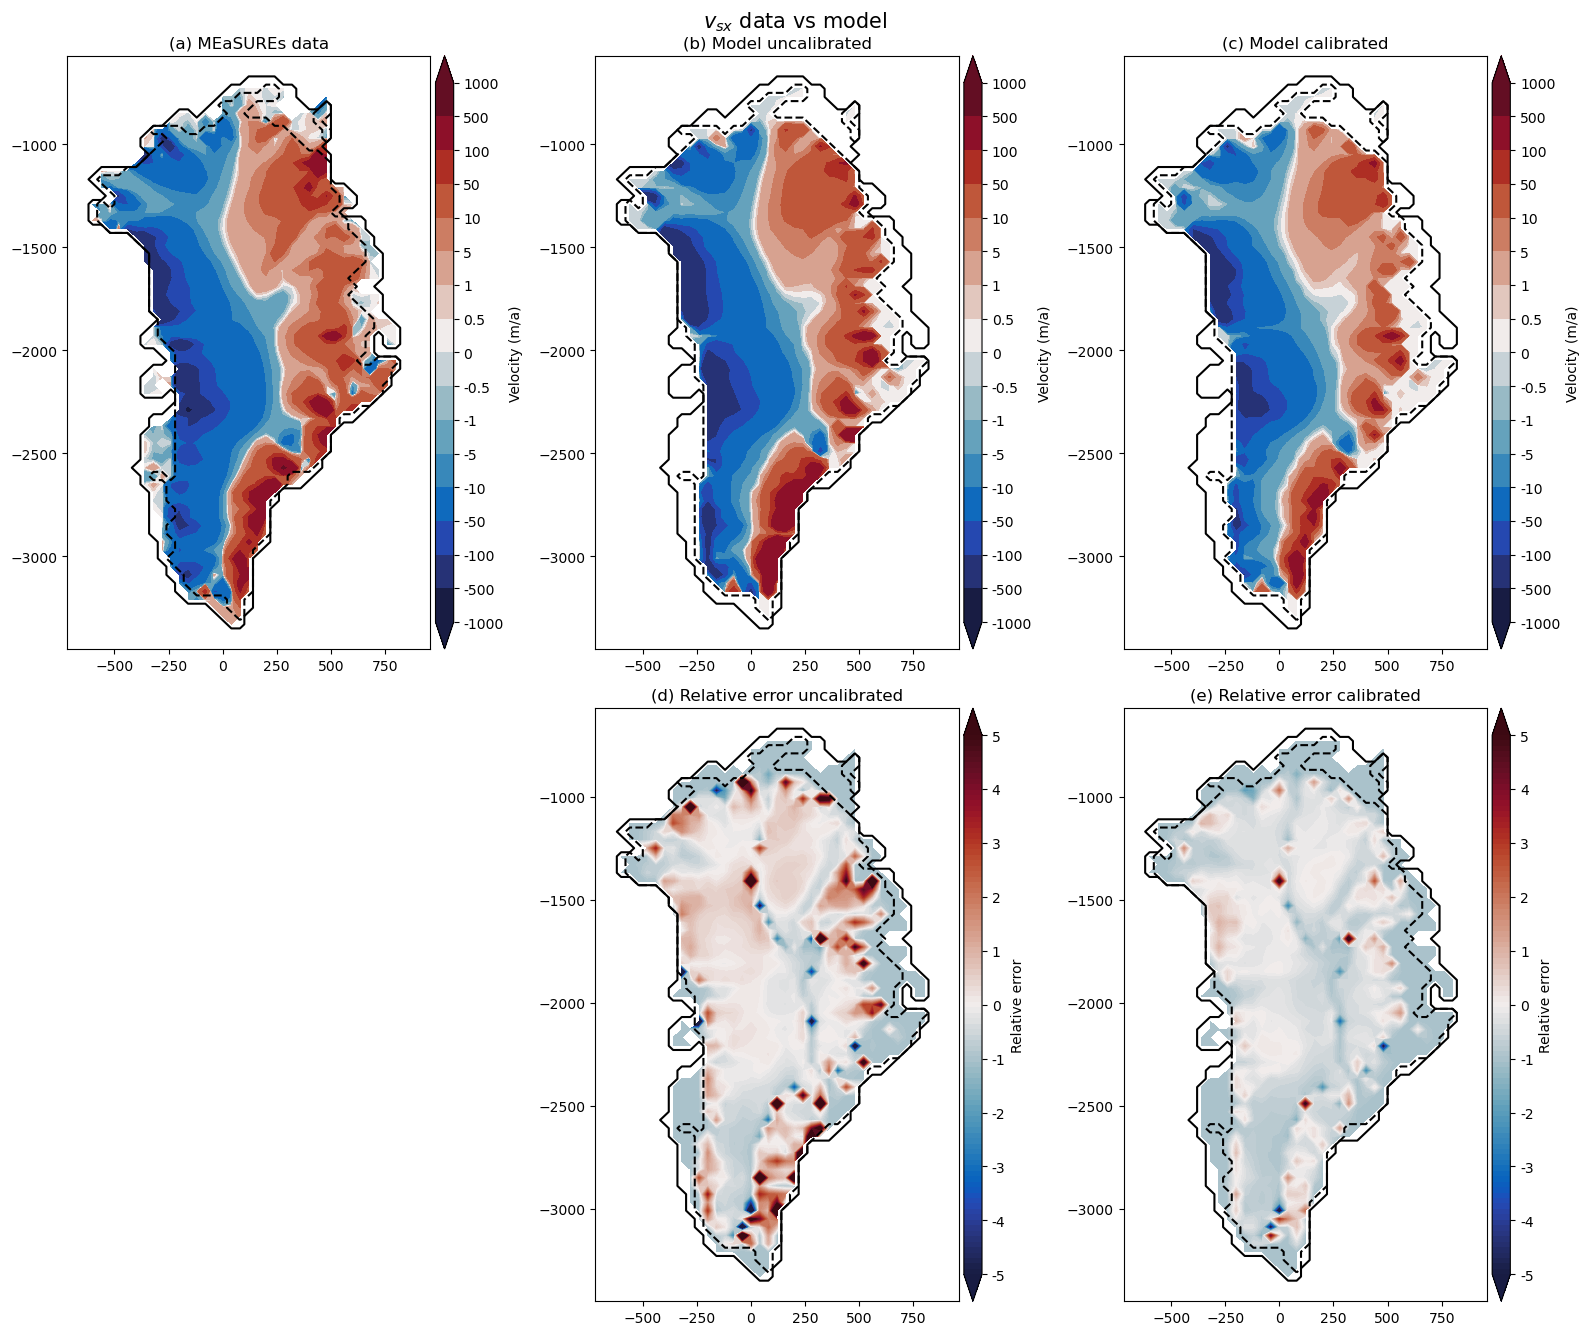

In [5]:
n_rows, n_cols = 2, 3
aspect_ratio = len(ds_surfvel_model_40km_nottuned['x'])/len(ds_surfvel_model_40km_nottuned['y'])
subplot_width = 4
subplot_height = subplot_width / aspect_ratio

plt.rcParams["figure.figsize"] = ((n_cols+1.0)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

# --- Define levels (notice that we skip 0, and keep ±0.5 as the neutral region)
levels = [-1000.0, -500.0, -100.0, -50.0, -10.0, -5.0, -1.0, -0.5, 0.0,
          0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]

# --- Get diverging colormap and sample colors uniformly
cmap = cmocean.cm.balance
n_intervals = len(levels) - 1
colors = [cmap(i / n_intervals) for i in range(n_intervals)]

# Plot discrete contourf on the existing ax
im = ax[0, 0].contourf(
    ds_surfvel_data_40km['x'],
    ds_surfvel_data_40km['y'],
    vx_data_nan,  # or vx_data field you're plotting
    levels=levels,
    colors=colors,
    extend='both'
)

ax[0, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

# Attach a new colorbar to this ax
divider = make_axes_locatable(ax[0, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(im, cax=cax, ticks=levels, spacing='uniform')

# Label and format
cb.set_label("Velocity (m/a)")
cb.ax.set_yticklabels([f"{lev:g}" for lev in levels])
ax[0, 0].set_title("(a) MEaSUREs data")

# Plot discrete contourf on the existing ax
im = ax[0, 1].contourf(
    ds_surfvel_data_40km['x'],
    ds_surfvel_data_40km['y'],
    vx_model_nottuned_nan,  # or vx_data field you're plotting
    levels=levels,
    colors=colors,
    extend='both'
)

ax[0, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_nottuned, levels=[0], colors="black")
ax[0, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_nottuned, levels=[0], colors="black", linestyles = "dashed")

# Attach a new colorbar to this ax
divider = make_axes_locatable(ax[0, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(im, cax=cax, ticks=levels, spacing='uniform')

# Label and format
cb.set_label("Velocity (m/a)")
cb.ax.set_yticklabels([f"{lev:g}" for lev in levels])
ax[0, 1].set_title("(b) Model uncalibrated")

# Plot discrete contourf on the existing ax
im = ax[0, 2].contourf(
    ds_surfvel_data_40km['x'],
    ds_surfvel_data_40km['y'],
    vx_model_tuned_nan,  # or vx_data field you're plotting
    levels=levels,
    colors=colors,
    extend='both'
)

ax[0, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

# Attach a new colorbar to this ax
divider = make_axes_locatable(ax[0, 2])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(im, cax=cax, ticks=levels, spacing='uniform')

# Label and format
cb.set_label("Velocity (m/a)")
cb.ax.set_yticklabels([f"{lev:g}" for lev in levels])
ax[0, 2].set_title("(c) Model calibrated")

plot_normal_new(ds_surfvel_data_40km['x'], 
                         ds_surfvel_data_40km['y'], 
                         np.clip(vx_model_nottuned/vx_data - 1, -10, 10),
                         cmap = 'cmo.balance', nbins = 100, vmin = -5, vmax = 5,
                         fig = fig, ax = ax[1, 1],
                         cbar_label = "Relative error", cbar_ticks=[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_nottuned, levels=[0], colors="black")
ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_nottuned, levels=[0], colors="black", linestyles = "dashed")
ax[1, 1].set_title("(d) Relative error uncalibrated")

plot_normal_new(ds_surfvel_data_40km['x'], 
                         ds_surfvel_data_40km['y'], 
                         np.clip(vx_model_tuned/vx_data - 1, -10, 10),
                         cmap = 'cmo.balance', nbins = 100, vmin = -5, vmax = 5,
                         fig = fig, ax = ax[1, 2],
                         cbar_label = "Relative error", cbar_ticks=[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
ax[1, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[1, 2].set_title("(e) Relative error calibrated")

# Hide or remove the empty subplot
fig.delaxes(ax[1, 0])      # completely removes it
# OR
ax[1, 0].set_visible(False)  # keeps it in layout but hides borders/ticks

plt.suptitle("$v_{sx}$ data vs model", fontsize=15)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_6/vx_data_model.png")

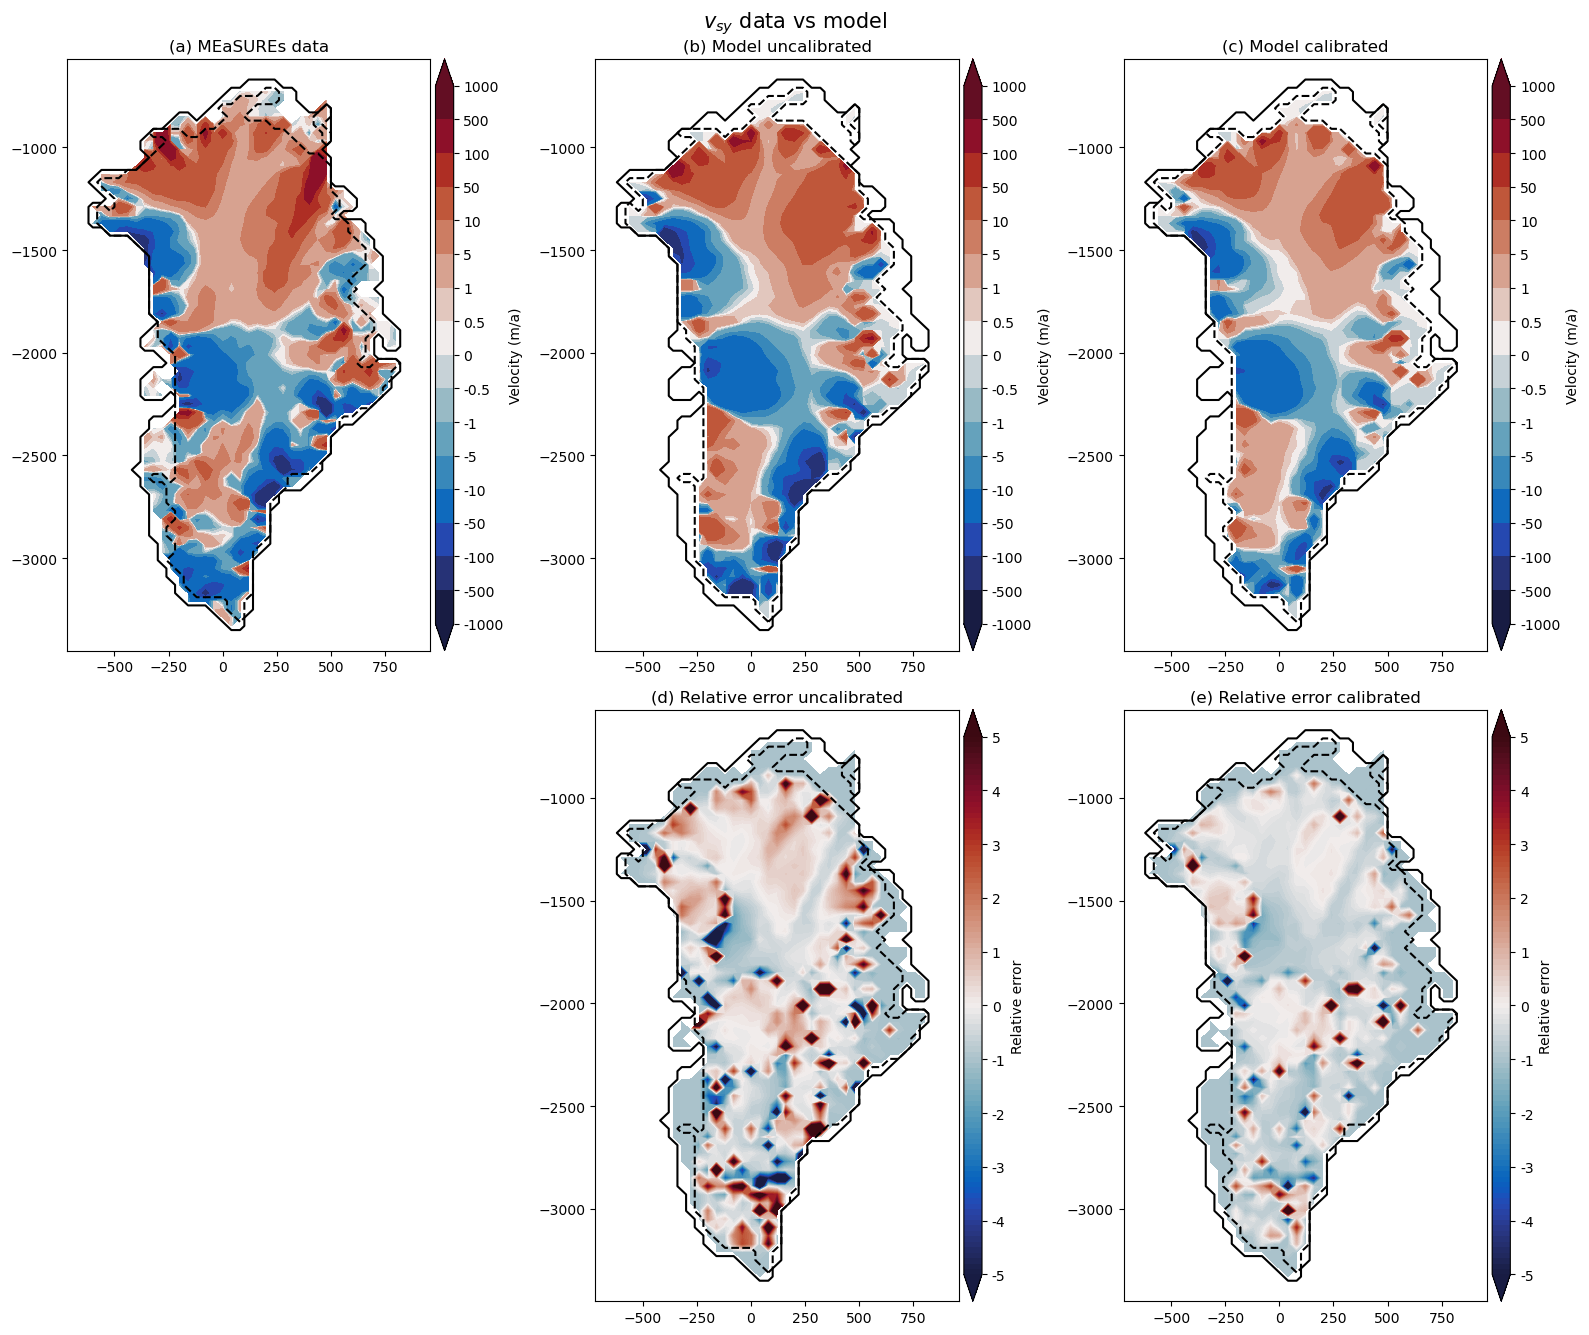

In [6]:
n_rows, n_cols = 2, 3
aspect_ratio = len(ds_surfvel_model_40km_nottuned['x'])/len(ds_surfvel_model_40km_nottuned['y'])
subplot_width = 4
subplot_height = subplot_width / aspect_ratio

plt.rcParams["figure.figsize"] = ((n_cols+1.0)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

# --- Define levels (notice that we skip 0, and keep ±0.5 as the neutral region)
levels = [-1000.0, -500.0, -100.0, -50.0, -10.0, -5.0, -1.0, -0.5, 0.0,
          0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]

# --- Get diverging colormap and sample colors uniformly
cmap = cmocean.cm.balance
n_intervals = len(levels) - 1
colors = [cmap(i / n_intervals) for i in range(n_intervals)]

# Plot discrete contourf on the existing ax
im = ax[0, 0].contourf(
    ds_surfvel_data_40km['x'],
    ds_surfvel_data_40km['y'],
    vy_data_nan,  # or vy_data field you're plotting
    levels=levels,
    colors=colors,
    extend='both'
)

ax[0, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

# Attach a new colorbar to this ax
divider = make_axes_locatable(ax[0, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(im, cax=cax, ticks=levels, spacing='uniform')

# Label and format
cb.set_label("Velocity (m/a)")
cb.ax.set_yticklabels([f"{lev:g}" for lev in levels])
ax[0, 0].set_title("(a) MEaSUREs data")

# Plot discrete contourf on the existing ax
im = ax[0, 1].contourf(
    ds_surfvel_data_40km['x'],
    ds_surfvel_data_40km['y'],
    vy_model_nottuned_nan,  # or vy_data field you're plotting
    levels=levels,
    colors=colors,
    extend='both'
)

ax[0, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_nottuned, levels=[0], colors="black")
ax[0, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_nottuned, levels=[0], colors="black", linestyles = "dashed")

# Attach a new colorbar to this ax
divider = make_axes_locatable(ax[0, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(im, cax=cax, ticks=levels, spacing='uniform')

# Label and format
cb.set_label("Velocity (m/a)")
cb.ax.set_yticklabels([f"{lev:g}" for lev in levels])
ax[0, 1].set_title("(b) Model uncalibrated")

# Plot discrete contourf on the existing ax
im = ax[0, 2].contourf(
    ds_surfvel_data_40km['x'],
    ds_surfvel_data_40km['y'],
    vy_model_tuned_nan,  # or vy_data field you're plotting
    levels=levels,
    colors=colors,
    extend='both'
)

ax[0, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")

# Attach a new colorbar to this ax
divider = make_axes_locatable(ax[0, 2])
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = plt.colorbar(im, cax=cax, ticks=levels, spacing='uniform')

# Label and format
cb.set_label("Velocity (m/a)")
cb.ax.set_yticklabels([f"{lev:g}" for lev in levels])
ax[0, 2].set_title("(c) Model calibrated")

plot_normal_new(ds_surfvel_data_40km['x'], 
                         ds_surfvel_data_40km['y'], 
                         np.clip(vy_model_nottuned/vy_data - 1, -10, 10),
                         cmap = 'cmo.balance', nbins = 100, vmin = -5, vmax = 5,
                         fig = fig, ax = ax[1, 1],
                         cbar_label = "Relative error", cbar_ticks=[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_nottuned, levels=[0], colors="black")
ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_nottuned, levels=[0], colors="black", linestyles = "dashed")
ax[1, 1].set_title("(d) Relative error uncalibrated")

plot_normal_new(ds_surfvel_data_40km['x'], 
                         ds_surfvel_data_40km['y'], 
                         np.clip(vy_model_tuned/vy_data - 1, -10, 10),
                         cmap = 'cmo.balance', nbins = 100, vmin = -5, vmax = 5,
                         fig = fig, ax = ax[1, 2],
                         cbar_label = "Relative error", cbar_ticks=[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
ax[1, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[1, 2].set_title("(e) Relative error calibrated")

# Hide or remove the empty subplot
fig.delaxes(ax[1, 0])      # completely removes it
# OR
ax[1, 0].set_visible(False)  # keeps it in layout but hides borders/ticks

plt.suptitle("$v_{sy}$ data vs model", fontsize=15)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_6/vy_data_model.png")

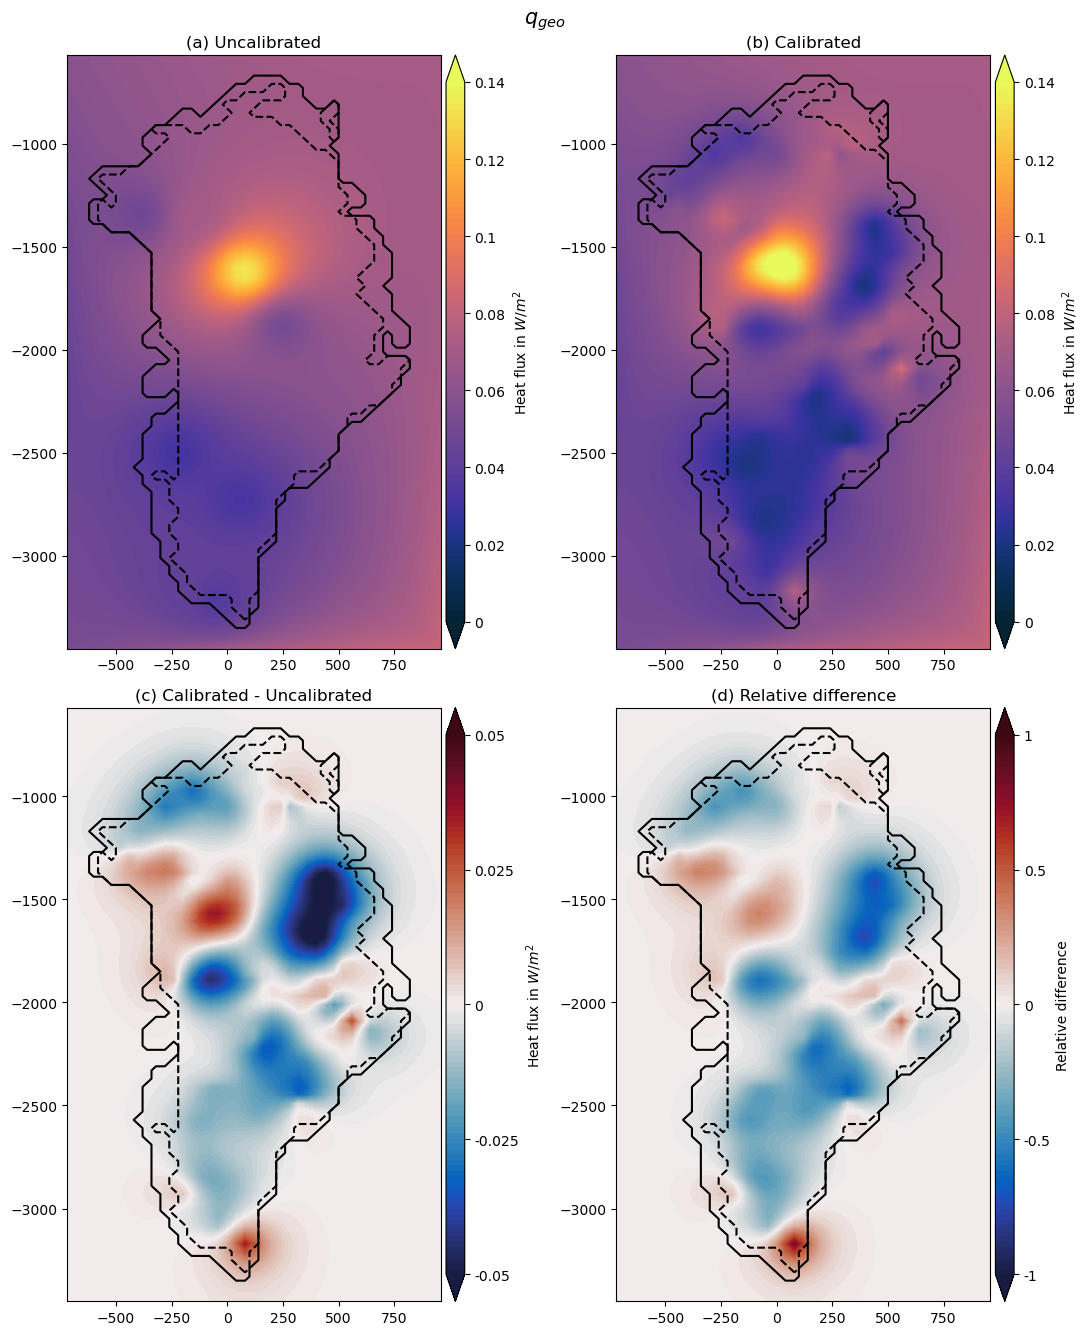

In [7]:
n_rows, n_cols = 2, 2
aspect_ratio = len(ds_surfvel_model_40km_nottuned['x'])/len(ds_surfvel_model_40km_nottuned['y'])
subplot_width = 4
subplot_height = subplot_width / aspect_ratio

plt.rcParams["figure.figsize"] = ((n_cols+0.75)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

plot_normal_new(ds_surfvel_data_40km['x'], 
                         ds_surfvel_data_40km['y'], 
                         10**ds_state_0["xx_q_geo"].data,
                         cmap = 'cmo.thermal', nbins = 100, vmin = 0, vmax = 0.14, center = 0.075,
                         fig = fig, ax = ax[0, 0],
                         cbar_label = r"Heat flux in $W/m^2$", cbar_ticks=[0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14])
ax[0, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[0, 0].set_title("(a) Uncalibrated")

plot_normal_new(ds_surfvel_data_40km['x'], 
                         ds_surfvel_data_40km['y'], 
                         10**ds_state["xx_q_geo"].data,
                         cmap = 'cmo.thermal', nbins = 100, vmin = 0, vmax = 0.14, center = 0.075,
                         fig = fig, ax = ax[0, 1],
                         cbar_label = r"Heat flux in $W/m^2$", cbar_ticks=[0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14])
ax[0, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[0, 1].set_title("(b) Calibrated")

plot_normal_new(ds_surfvel_data_40km['x'], 
                         ds_surfvel_data_40km['y'], 
                         10**ds_state["xx_q_geo"].data-10**ds_state_0["xx_q_geo"].data,
                         cmap = 'cmo.balance', nbins = 100, vmin = -0.05, vmax = 0.05, center = 0.0,
                         fig = fig, ax = ax[1, 0],
                         cbar_label = r"Heat flux in $W/m^2$", cbar_ticks=[-0.05, -0.025, 0, 0.025, 0.05])
ax[1, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[1, 0].set_title(r"(c) Calibrated - Uncalibrated")

plot_normal_new(ds_surfvel_data_40km['x'], 
                         ds_surfvel_data_40km['y'], 
                         10**ds_state["xx_q_geo"].data/10**ds_state_0["xx_q_geo"].data - 1,
                         cmap = 'cmo.balance', nbins = 100, vmin = -1.0, vmax = 1.0, center = 0.0,
                         fig = fig, ax = ax[1, 1],
                         cbar_label = r"Relative difference", cbar_ticks=[-1.0, -0.5, 0.0, 0.5, 1.0])
ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[1, 1].set_title(r"(d) Relative difference")

plt.suptitle("$q_{geo}$", fontsize=15)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_6/q_geo_calibrated.png")

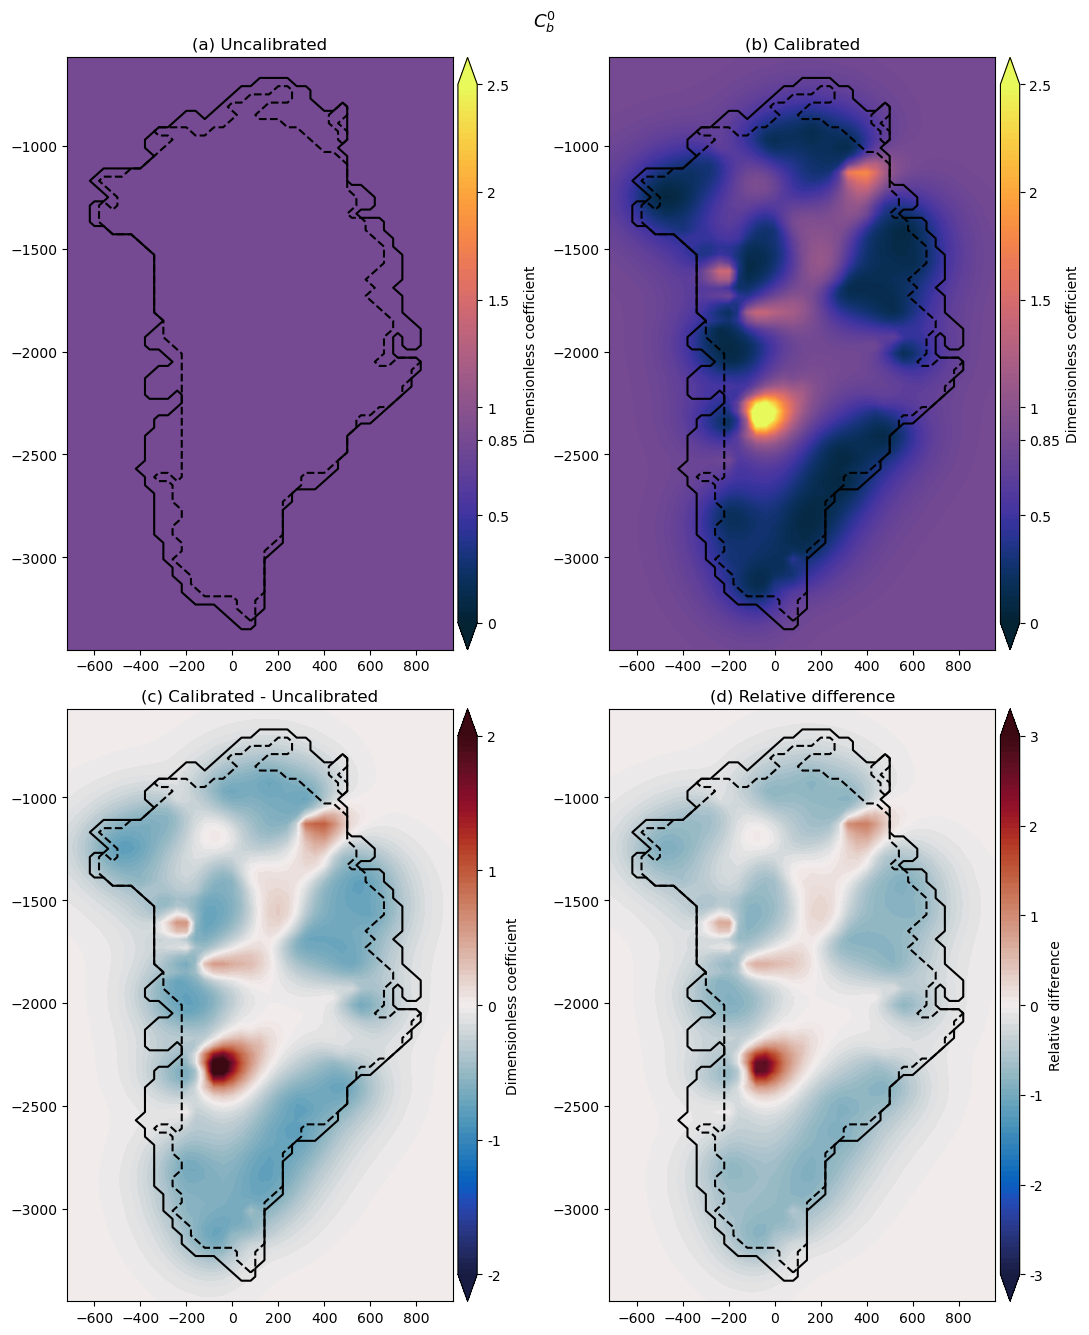

In [8]:
n_rows, n_cols = 2, 2
aspect_ratio = len(ds_surfvel_model_40km_nottuned['x'])/len(ds_surfvel_model_40km_nottuned['y'])
subplot_width = 4
subplot_height = subplot_width / aspect_ratio

plt.rcParams["figure.figsize"] = ((n_cols+0.75)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

plot_normal_new(ds_surfvel_data_40km['x'], 
                         ds_surfvel_data_40km['y'], 
                         10**ds_state_0["xx_c_slide_init"].data,
                         cmap = 'cmo.thermal', nbins = 100, vmin = 0, vmax = 2.5, center = 1.25,
                         fig = fig, ax = ax[0, 0],
                         cbar_label = r"Dimensionless coefficient", cbar_ticks=[0, 0.5, 0.85, 1.0, 1.5, 2.0, 2.5])
ax[0, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[0, 0].set_title("(a) Uncalibrated")

plot_normal_new(ds_surfvel_data_40km['x'], 
                         ds_surfvel_data_40km['y'], 
                         10**ds_state["xx_c_slide_init"].data,
                         cmap = 'cmo.thermal', nbins = 100, vmin = 0, vmax = 2.5, center = 1.25,
                         fig = fig, ax = ax[0, 1],
                         cbar_label = r"Dimensionless coefficient", cbar_ticks=[0, 0.5, 0.85, 1.0, 1.5, 2.0, 2.5])
ax[0, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[0, 1].set_title("(b) Calibrated")

plot_normal_new(ds_surfvel_data_40km['x'], 
                         ds_surfvel_data_40km['y'], 
                         10**ds_state["xx_c_slide_init"].data-10**ds_state_0["xx_c_slide_init"].data,
                         cmap = 'cmo.balance', nbins = 100, vmin = -2.0, vmax = 2.0, center = 0.0,
                         fig = fig, ax = ax[1, 0],
                         cbar_label = r"Dimensionless coefficient", cbar_ticks=[-2.0, -1.0, 0.0, 1.0, 2.0])
ax[1, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[1, 0].set_title(r"(c) Calibrated - Uncalibrated")

plot_normal_new(ds_surfvel_data_40km['x'], 
                         ds_surfvel_data_40km['y'], 
                         10**ds_state["xx_c_slide_init"].data/10**ds_state_0["xx_c_slide_init"].data - 1,
                         cmap = 'cmo.balance', nbins = 100, vmin = -3.0, vmax = 3.0, center = 0.0,
                         fig = fig, ax = ax[1, 1],
                         cbar_label = r"Relative difference", cbar_ticks=[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0])
ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[1, 1].set_title(r"(d) Relative difference")

plt.suptitle("$C_b^0$", fontsize=13)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_6/c_slide_init_calibrated.png")

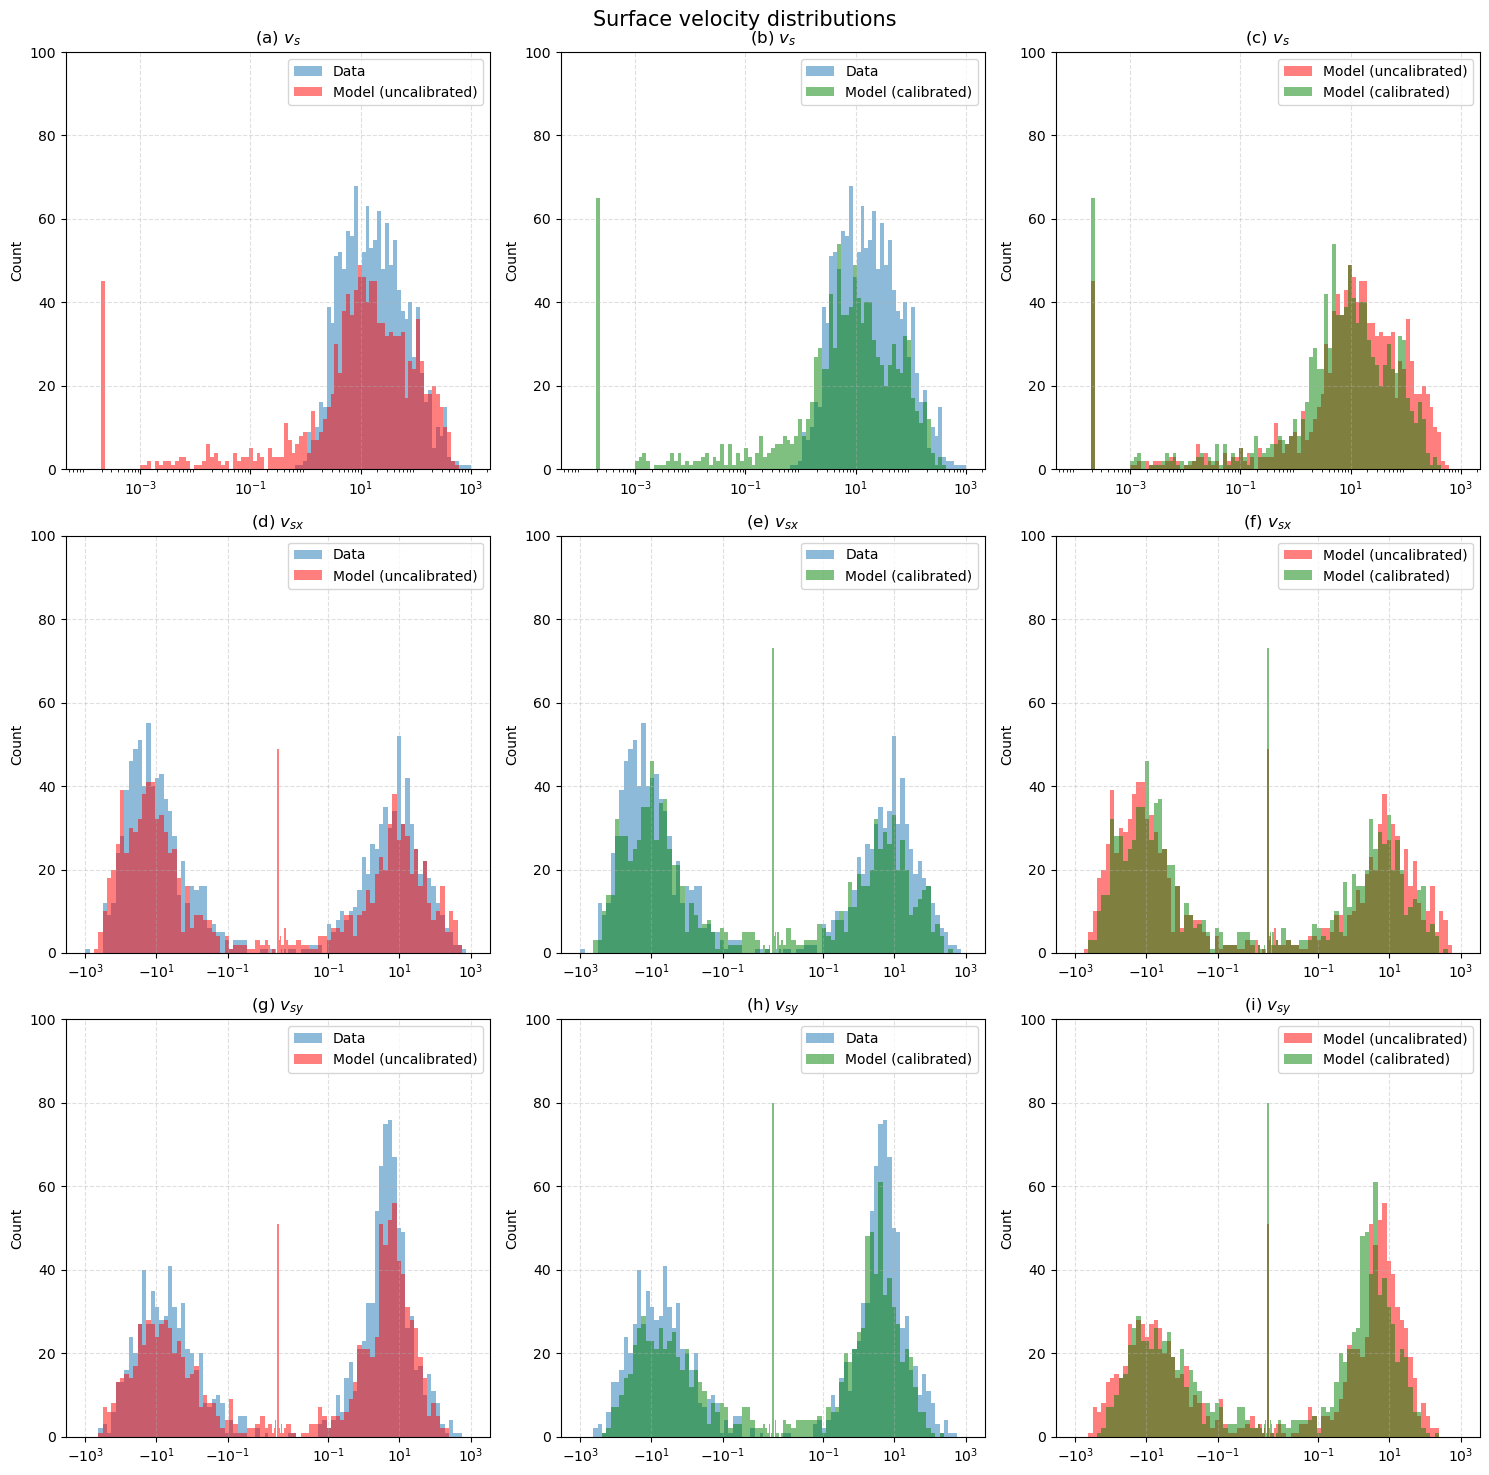

In [10]:
def filter_small(x, threshold=0.001):

    y = x.copy()
    y[np.abs(y) < threshold] = np.sign(y)[np.abs(y) < threshold] * threshold / 5.0
    return y
    # return x.copy()
    # return x[(x <= -threshold) | (x >= threshold)]

# Define log-spaced bins
thres = 1.e-3
n_bins_surfvel = 101
n_bins_components = n_bins_surfvel // 2
bins = np.logspace(np.log10(thres/10.0), np.log10(1000), n_bins_surfvel-1)

# Flatten arrays
data = filter_small(np.ravel(vs_data_nan), threshold = thres)
model_nottuned = filter_small(np.ravel(vs_model_nottuned_nan), threshold = thres)
model_tuned = filter_small(np.ravel(vs_model_tuned_nan), threshold = thres)

# Create subplots
plt.rcParams["figure.figsize"] = (15, 15)
fig, ax = plt.subplots(3, 3)

# Example plot in the first subplot
ax[0, 0].hist(data, bins=bins, alpha=0.5, label='Data')
ax[0, 0].hist(model_nottuned, bins=bins, alpha=0.5, label='Model (uncalibrated)', color = "red")

# Log scale on that specific axis
ax[0, 0].set_xscale('log')
ax[0, 0].set_xticks([0.001, 0.1, 10, 1000])

# Axis labels, legend, grid for that subplot
ax[0, 0].set_title('(a) $v_s$')
ax[0, 0].set_ylabel('Count')
ax[0, 0].legend()
ax[0, 0].grid(True, which='major', ls='--', alpha=0.4)
ax[0, 0].grid(False, which='minor')
ax[0, 0].set_ylim(0, 100)

ax[0, 1].hist(data, bins=bins, alpha=0.5, label='Data')
ax[0, 1].hist(model_tuned, bins=bins, alpha=0.5, label='Model (calibrated)', color = "green")

# Log scale on that specific axis
ax[0, 1].set_xscale('log')
ax[0, 1].set_xticks([0.001, 0.1, 10, 1000])

# Axis labels, legend, grid for that subplot
ax[0, 1].set_title('(b) $v_s$')
ax[0, 1].set_ylabel('Count')
ax[0, 1].legend()
ax[0, 1].grid(True, which='major', ls='--', alpha=0.4)
ax[0, 1].grid(False, which='minor')
ax[0, 1].set_ylim(0, 100)

ax[0, 2].hist(model_nottuned, bins=bins, alpha=0.5, label='Model (uncalibrated)', color = "red")
ax[0, 2].hist(model_tuned, bins=bins, alpha=0.5, label='Model (calibrated)', color = "green")

# Log scale on that specific axis
ax[0, 2].set_xscale('log')
ax[0, 2].set_xticks([0.001, 0.1, 10, 1000])

# Axis labels, legend, grid for that subplot
ax[0, 2].set_title('(c) $v_s$')
ax[0, 2].set_ylabel('Count')
ax[0, 2].legend()
ax[0, 2].grid(True, which='major', ls='--', alpha=0.4)
ax[0, 2].grid(False, which='minor')
ax[0, 2].set_ylim(0, 100)

# Define symmetric log-spaced bins
pos_bins = np.logspace(np.log10(thres), np.log10(1000), n_bins_components)
neg_bins = -pos_bins[::-1]
bins = np.concatenate((neg_bins, pos_bins))

# Flatten and filter arrays (keep sign)
data = filter_small(np.ravel(vx_data_nan), threshold = thres)
model_nottuned = filter_small(np.ravel(vx_model_nottuned_nan), threshold = thres)
model_tuned = filter_small(np.ravel(vx_model_tuned_nan), threshold = thres)

# Example subplot
ax[1, 0].hist(data, bins=bins, alpha=0.5, label='Data')
ax[1, 0].hist(model_nottuned, bins=bins, alpha=0.5, label='Model (uncalibrated)', color="red")
ax[1, 0].set_xscale('symlog', linthresh=0.05)
ax[1, 0].set_title('(d) $v_{sx}$')
ax[1, 0].set_ylabel('Count')
ax[1, 0].legend()
ax[1, 0].grid(True, which='major', ls='--', alpha=0.4)
ax[1, 0].grid(False, which='minor')
ax[1, 0].set_ylim(0, 100)

ax[1, 0].set_xscale('symlog', linthresh=0.05)
ax[1, 0].set_xticks([-1000, -10, -0.1, 0.1, 10, 1000])
ax[1, 0].tick_params(axis='x', which='minor', bottom=False)

# Example subplot
ax[1, 1].hist(data, bins=bins, alpha=0.5, label='Data')
ax[1, 1].hist(model_tuned, bins=bins, alpha=0.5, label='Model (calibrated)', color="green")
ax[1, 1].set_xscale('symlog', linthresh=0.05)
ax[1, 1].set_title('(e) $v_{sx}$')
ax[1, 1].set_ylabel('Count')
ax[1, 1].legend()
ax[1, 1].grid(True, which='major', ls='--', alpha=0.4)
ax[1, 1].grid(False, which='minor')
ax[1, 1].set_ylim(0, 100)

ax[1, 1].set_xscale('symlog', linthresh=0.05)
ax[1, 1].set_xticks([-1000, -10, -0.1, 0.1, 10, 1000])
ax[1, 1].tick_params(axis='x', which='minor', bottom=False)

# Example subplot
ax[1, 2].hist(model_nottuned, bins=bins, alpha=0.5, label='Model (uncalibrated)', color="red")
ax[1, 2].hist(model_tuned, bins=bins, alpha=0.5, label='Model (calibrated)', color="green")
ax[1, 2].set_xscale('symlog', linthresh=0.05)
ax[1, 2].set_title('(f) $v_{sx}$')
ax[1, 2].set_ylabel('Count')
ax[1, 2].legend()
ax[1, 2].grid(True, which='major', ls='--', alpha=0.4)
ax[1, 2].grid(False, which='minor')
ax[1, 2].set_ylim(0, 100)

ax[1, 2].set_xscale('symlog', linthresh=0.05)
ax[1, 2].set_xticks([-1000, -10, -0.1, 0.1, 10, 1000])
ax[1, 2].tick_params(axis='x', which='minor', bottom=False)

# Define symmetric log-spaced bins
pos_bins = np.logspace(np.log10(thres), np.log10(1000), n_bins_components)
neg_bins = -pos_bins[::-1]
bins = np.concatenate((neg_bins, pos_bins))

# Flatten and filter arrays (keep sign)
data = filter_small(np.ravel(vy_data_nan), threshold = thres)
model_nottuned = filter_small(np.ravel(vy_model_nottuned_nan), threshold = thres)
model_tuned = filter_small(np.ravel(vy_model_tuned_nan), threshold = thres)

# Example subplot
ax[2, 0].hist(data, bins=bins, alpha=0.5, label='Data')
ax[2, 0].hist(model_nottuned, bins=bins, alpha=0.5, label='Model (uncalibrated)', color="red")
ax[2, 0].set_xscale('symlog', linthresh=0.05)
ax[2, 0].set_title('(g) $v_{sy}$')
ax[2, 0].set_ylabel('Count')
ax[2, 0].legend()
ax[2, 0].grid(True, which='major', ls='--', alpha=0.4)
ax[2, 0].grid(False, which='minor')
ax[2, 0].set_ylim(0, 100)

ax[2, 0].set_xscale('symlog', linthresh=0.05)
ax[2, 0].set_xticks([-1000, -10, -0.1, 0.1, 10, 1000])
ax[2, 0].tick_params(axis='x', which='minor', bottom=False)

# Example subplot
ax[2, 1].hist(data, bins=bins, alpha=0.5, label='Data')
ax[2, 1].hist(model_tuned, bins=bins, alpha=0.5, label='Model (calibrated)', color="green")
ax[2, 1].set_xscale('symlog', linthresh=0.05)
ax[2, 1].set_title('(h) $v_{sy}$')
ax[2, 1].set_ylabel('Count')
ax[2, 1].legend()
ax[2, 1].grid(True, which='major', ls='--', alpha=0.4)
ax[2, 1].grid(False, which='minor')
ax[2, 1].set_ylim(0, 100)

ax[2, 1].set_xscale('symlog', linthresh=0.05)
ax[2, 1].set_xticks([-1000, -10, -0.1, 0.1, 10, 1000])
ax[2, 1].tick_params(axis='x', which='minor', bottom=False)

# Example subplot
ax[2, 2].hist(model_nottuned, bins=bins, alpha=0.5, label='Model (uncalibrated)', color="red")
ax[2, 2].hist(model_tuned, bins=bins, alpha=0.5, label='Model (calibrated)', color="green")
ax[2, 2].set_xscale('symlog', linthresh=0.05)
ax[2, 2].set_title('(i) $v_{sy}$')
ax[2, 2].set_ylabel('Count')
ax[2, 2].legend()
ax[2, 2].grid(True, which='both', ls='--', alpha=0.4)
ax[2, 2].grid(False, which='minor')
ax[2, 2].set_ylim(0, 100)

ax[2, 2].set_xscale('symlog', linthresh=0.05)
ax[2, 2].set_xticks([-1000, -10, -0.1, 0.1, 10, 1000])
ax[2, 2].tick_params(axis='x', which='minor', bottom=False)

plt.suptitle("Surface velocity distributions", fontsize=15)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_6/pI_reduced_surfvel.png")

In [ ]:
plt.rcParams["figure.figsize"] = (7, 10)
fig, ax = plt.subplots(3, 1)

bins = np.r_[1000.0, np.logspace(np.log10(1230.5582908431006), np.log10(100000.0), 101)]

ax[0].axvline(1419.2834255941564, color = "green", label="Posterior mean (MAP)")
ax[0].axvline(11602.203786448743, color = "red", label="Prior mean")
ax[0].hist(prior_samples_fc, bins=bins, color = "red", alpha=0.5, label="Prior samples")
ax[0].axvline(np.mean(prior_samples_fc), color = "red", linestyle='--', label="Mean of prior samples")
ax[0].hist(posterior_samples_fc, bins=bins, color = "green", alpha=0.5, label="Posterior samples")
ax[0].axvline(np.mean(posterior_samples_fc), color = "green", linestyle='--', label="Mean of posterior samples")
ax[0].set_title("Total cost")
ax[0].set_ylim(0.0, 500)
ax[0].legend(loc = "upper right", ncol=2, framealpha=1.0)
ax[0].set_ylabel('Count')
ax[0].set_xscale('log')
ax[0].set_xticks([1000.0, 10000.0, 100000.0])

ax[1].axvline(1230.5582908431006, color = "green", label="Posterior mean (MAP)")
ax[1].axvline(11602.203786448743, color = "red", label="Prior mean")
ax[1].hist(prior_samples_fc_data, bins=bins, color = "red", alpha=0.5, label="Prior samples")
ax[1].axvline(np.mean(prior_samples_fc_data), color = "red", linestyle='--', label="Mean of prior samples")
ax[1].hist(posterior_samples_fc_data, bins=bins, color = "green", alpha=0.5, label="Posterior samples")
ax[1].axvline(np.mean(posterior_samples_fc_data), color = "green", linestyle='--', label="Mean of posterior samples")
ax[1].set_title("Model-data misfit cost")
ax[1].set_ylim(0.0, 500)
ax[1].legend(loc = "upper right", ncol=2, framealpha=1.0)
ax[1].set_ylabel('Count')
ax[1].set_xscale('log')
ax[1].set_xticks([1000.0, 10000.0, 100000.0])

ax[2].axvline(188.7251347510557, color = "green", label="Posterior mean (MAP)")
ax[2].axvline(0.0, color = "red", label="Prior mean")
ax[2].hist(prior_samples_fc_reg, color = "red", alpha=0.5, label="Prior samples")
ax[2].axvline(np.mean(prior_samples_fc_reg), color = "red", linestyle='--', label="Mean of prior samples")
ax[2].hist(posterior_samples_fc_reg, color = "green", alpha=0.5, label="Posterior samples")
ax[2].axvline(np.mean(posterior_samples_fc_reg), color = "green", linestyle='--', label="Mean of posterior samples")
ax[2].set_title("Regularization cost")
ax[2].set_ylim(0.0, 500)
ax[2].legend(loc = "upper right", ncol=2, framealpha=1.0)
ax[2].set_ylabel('Count')

plt.suptitle("Cost analysis of prior and posterior samples", fontsize=12)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_6/pI_prior_posterior_samples_cost.png")

In [ ]:
n_rows, n_cols = 2, 3
aspect_ratio = len(ds_surfvel_model_40km_nottuned['x'])/len(ds_surfvel_model_40km_nottuned['y'])
subplot_width = 4
subplot_height = subplot_width / aspect_ratio

plt.rcParams["figure.figsize"] = ((n_cols+1.0)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

plot_normal_new(ds_surfvel_data_40km['x'], 
                         ds_surfvel_data_40km['y'], 
                         10**ds_state_0["xx_c_slide_init"].data,
                         cmap = 'cmo.thermal', nbins = 100, vmin = 0, vmax = 2.5, center = 1.25,
                         fig = fig, ax = ax[0, 0],
                         cbar_label = r"Dimensionless coefficient", cbar_ticks=[0, 0.5, 0.85, 1.0, 1.5, 2.0, 2.5])
ax[0, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[0, 0].set_title(r"(a) Prior mean of $C_b^0$")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                ds_std_prior["xx_c_slide_initd"].data**2,
                cmap = cmo.ice, 
                nbins = 100, vmin = 0, vmax = 0.09, center = 0.045,
                fig = fig, ax = ax[0, 1],
                cbar_label = "Variance of dimensionless coefficient", cbar_ticks=[0.0, 0.03, 0.06, 0.09])
ax[0, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[0, 1].set_title(r"(b) Prior marginal variance of $\log_{10}(C_b^0)$")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                10**(ds_state_0["xx_c_slide_init"].data + ds_sample_prior_1["xx_c_slide_initd"].data),
                cmap = cmo.thermal, 
                nbins = 100, vmin = 0, vmax = 2.5, center = 1.25,
                fig = fig, ax = ax[0, 2],
                cbar_label = "Dimensionless coefficient", cbar_ticks=[0, 0.5, 0.85, 1.0, 1.5, 2.0, 2.5])
ax[0, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[0, 2].set_title(r"(c) Sample of $C_b^0$ from the prior")

plot_normal_new(ds_surfvel_data_40km['x'], 
                         ds_surfvel_data_40km['y'], 
                         10**ds_state["xx_c_slide_init"].data,
                         cmap = 'cmo.thermal', nbins = 100, vmin = 0, vmax = 2.5, center = 1.25,
                         fig = fig, ax = ax[1, 0],
                         cbar_label = r"Dimensionless coefficient", cbar_ticks=[0, 0.5, 0.85, 1.0, 1.5, 2.0, 2.5])
ax[1, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[1, 0].set_title(r"(a) Posterior mean of $C_b^0$ (MAP)")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                ds_std_posterior["xx_c_slide_initd"].data**2,
                cmap = cmo.ice, 
                nbins = 100, vmin = 0, vmax = 0.09, center = 0.045,
                fig = fig, ax = ax[1, 1],
                cbar_label = "Variance of dimensionless coefficient", cbar_ticks=[0.0, 0.03, 0.06, 0.09])
ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[1, 1].set_title(r"(b) Posterior marginal variance of $\log_{10}(C_b^0)$")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                10**(ds_state["xx_c_slide_init"].data + ds_sample_posterior_1["xx_c_slide_initd"].data),
                cmap = cmo.thermal, 
                nbins = 100, vmin = 0, vmax = 2.5, center = 1.25,
                fig = fig, ax = ax[1, 2],
                cbar_label = "Dimensionless coefficient", cbar_ticks=[0, 0.5, 0.85, 1.0, 1.5, 2.0, 2.5])
ax[1, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[1, 2].set_title(r"(c) Sample of $C_b^0$ from the posterior")

plt.suptitle("Prior and posterior for $C_b^0$", fontsize=15)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_6/c_slide_init_prior_posterior.png")

In [ ]:
n_rows, n_cols = 2, 3
aspect_ratio = len(ds_surfvel_model_40km_nottuned['x'])/len(ds_surfvel_model_40km_nottuned['y'])
subplot_width = 4
subplot_height = subplot_width / aspect_ratio

plt.rcParams["figure.figsize"] = ((n_cols+1.0)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                10**ds_state_0["xx_q_geo"].data,
                cmap = 'cmo.thermal', nbins = 100, vmin = 0, vmax = 0.14, center = 0.075,
                fig = fig, ax = ax[0, 0],
                cbar_label = r"Heat flux in $W/m^2$", cbar_ticks=[0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14])
ax[0, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[0, 0].set_title(r"(a) Prior mean of $q_{\text{geo}}$")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                ds_std_prior["xx_q_geod"].data**2,
                cmap = cmo.ice, nbins = 100, vmin = 0, vmax = 0.09, center = 0.045,
                fig = fig, ax = ax[0, 1],
                cbar_label = "Variance of heat flux in $W/m^2", cbar_ticks=[0.0, 0.03, 0.06, 0.09])
ax[0, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[0, 1].set_title(r"(b) Prior marginal variance of $\log_{10}(q_{\text{geo}})$")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                10**(ds_state_0["xx_q_geo"].data + ds_sample_prior_2["xx_q_geod"].data),
                cmap = 'cmo.thermal', nbins = 100, vmin = 0, vmax = 0.14, center = 0.075,
                fig = fig, ax = ax[0, 2],
                cbar_label = r"Heat flux in $W/m^2$", cbar_ticks=[0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14])
ax[0, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[0, 2].set_title(r"(c) Sample of $q_{\text{geo}}$ from the prior")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                10**ds_state["xx_q_geo"].data,
                cmap = 'cmo.thermal', nbins = 100, vmin = 0, vmax = 0.14, center = 0.075,
                fig = fig, ax = ax[1, 0],
                cbar_label = r"Heat flux in $W/m^2$", cbar_ticks=[0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14])
ax[1, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[1, 0].set_title(r"(a) Posterior mean of $q_{\text{geo}}$ (MAP)")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                ds_std_posterior["xx_q_geod"].data**2,
                cmap = cmo.ice, nbins = 100, vmin = 0, vmax = 0.09, center = 0.045,
                fig = fig, ax = ax[1, 1],
                cbar_label = "Variance of heat flux in $W/m^2", cbar_ticks=[0.0, 0.03, 0.06, 0.09])
ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[1, 1].set_title(r"(b) Posterior marginal variance of $\log_{10}(q_{\text{geo}})$")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                10**(ds_state["xx_q_geo"].data + ds_sample_posterior_1["xx_q_geod"].data),
                cmap = 'cmo.thermal', nbins = 100, vmin = 0, vmax = 0.14, center = 0.075,
                fig = fig, ax = ax[1, 2],
                cbar_label = r"Heat flux in $W/m^2$", cbar_ticks=[0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14])
ax[1, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[1, 2].set_title(r"(c) Sample of $q_{\text{geo}}$ from the posterior")

plt.suptitle("Prior and posterior for $q_{geo}$", fontsize=15)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_6/q_geo_prior_posterior.png")

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(np.arange(600), Lambda_misfit_sa, linestyle='-', color='blue')

plt.yscale('log')             # log scale on y-axis
plt.xlabel('Number')
plt.ylabel('Eigenvalues')
plt.title('Eigenspectrum of symmetric prior-preconditioned misfit Hessian (top 600 eigenvalues)')
plt.grid(True, which='major', ls='--', alpha=0.4)
plt.legend()

plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_6/pI_eigenspectrum.png")

In [ ]:
plt.rcParams["figure.figsize"] = (10, 5)
fig, ax = plt.subplots(1, 2)

ax[0].plot(np.arange(27), costs_final, linestyle='-', color='blue', marker = "o", label = "Total cost")
ax[0].plot(np.arange(27), misfits_final, linestyle='-', color='green', marker = "o", label = "Model-data misfit cost")
ax[0].axhline(one_sigma_threshold, linestyle='-', color='red', label = r"1$\sigma$ error equivalent")
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Cost')
ax[0].set_title('Cost vs iterations')
ax[0].grid(True, which='major', ls='--', alpha=0.4)
ax[0].legend()

ax[0].annotate(
    "Maximum step size reduced\nfrom 1.0 to 0.125 for stable adjoints",
    xy=(1, costs_final[1]),              # point to annotate
    xytext=(7, costs_final[1]*1.1),        # text position (to the right, slightly above)
    textcoords='data',
    arrowprops=dict(arrowstyle="->", color='black', lw=0.8),
    fontsize=10,
    ha='left'
)

# From /home/shreyas/pySICOPOLIS/examples/scripts/oS3p5_50_n_p2_6423.out
y = np.array([3494.4211889555404, 870.164077819417, 690.8922928397109, 546.8602203822537, 492.7247142025844, 418.7585102793357, 
              343.37356851955224, 289.4120915278772, 230.2059885247486, 213.8924489586184, 284.9147267770985, 214.3579658342665, 
              172.9501026683045, 151.12517691285936, 125.8704350517249, 106.56020718158625, 87.21123650230076, 72.3105187177666,
              56.11854874551669, 48.08051561804292, 37.779365308798056, 44.71630954324569, 49.742764028895884, 56.30039515616022, 
              49.57971753824275, 39.98053441661347])

ax[1].plot(np.arange(26), y, linestyle='-', color='blue', marker = "o")
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Norm')
ax[1].set_title('$0.5 \|\Gamma_{pr}^{1/2} g\|$ vs iterations')
ax[1].grid(True, which='major', ls='--', alpha=0.4)
ax[1].legend()

ax[1].annotate(
    "Maximum step size reduced\nfrom 1.0 to 0.125 for stable adjoints",
    xy=(1, y[1]),              # point to annotate
    xytext=(7, y[1]*1.1),        # text position (to the right, slightly above)
    textcoords='data',
    arrowprops=dict(arrowstyle="->", color='black', lw=0.8),
    fontsize=10,
    ha='left'
)

plt.suptitle("Stage I optimization using Inexact GN-Hessian CG Method", fontsize=12)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_6/pI_optim_iterations.png")

In [ ]:
n_rows, n_cols = 2, 3
aspect_ratio = len(ds_surfvel_model_40km_nottuned['x'])/len(ds_surfvel_model_40km_nottuned['y'])
subplot_width = 4
subplot_height = subplot_width / aspect_ratio

plt.rcParams["figure.figsize"] = ((n_cols+1.0)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                ds_prior_X["xx_c_slide_initd"].data**(-2),
                cmap = cmo.thermal, nbins = 100, vmin = 0, vmax = 1600, center = 800,
                fig = fig, ax = ax[0, 0],
                cbar_label = r"Marginal variance", cbar_ticks=[0, 400, 800, 1200, 1600])
ax[0, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[0, 0].set_title(r"(a) Marginal variance of Matern covariance $C$")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                ds_prior_X["xx_c_slide_initd"].data,
                cmap = cmo.thermal, nbins = 100, vmin = 0.025, vmax = 0.05, center = 0.0375,
                fig = fig, ax = ax[0, 1],
                cbar_label = r"Marginal standard deviation", cbar_ticks=[0.025, 0.03, 0.035, 0.04, 0.045, 0.05])
ax[0, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[0, 1].set_title(r"(b) Diagonal entries of $X$")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                ds_std_prior["xx_c_slide_initd"].data**2,
                cmap = cmo.thermal, nbins = 100, vmin = 0, vmax = 0.09, center = 0.045,
                fig = fig, ax = ax[0, 2],
                cbar_label = r"Marginal variance", cbar_ticks=[0.0, 0.03, 0.06, 0.09])
ax[0, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[0, 2].set_title(r"(c) Marginal variance of prior $\Gamma_{pr} = (\Sigma X C)(\Sigma X C)^T$")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                np.random.randn(73, 43),
                cmap = cmo.balance, 
                nbins = 100, vmin = -1, vmax = 1, center = 0.0,
                fig = fig, ax = ax[1, 0],
                cbar_label = "White noise sample", cbar_ticks=[-1.0, -0.5, 0.0, 0.5, 1.0])
ax[1, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[1, 0].set_title("(d) Spatially uncorrelated white noise")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                ds_sample_prior_1["xx_c_slide_initd"].data,
                cmap = cmo.balance, 
                nbins = 100, vmin = -1, vmax = 1, center = 0.0,
                fig = fig, ax = ax[1, 1],
                cbar_label = "Sample from prior", cbar_ticks=[-1.0, -0.5, 0.0, 0.5, 1.0])
ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[1, 1].set_title("(e) Sample from prior $\Gamma_{pr} = (\Sigma X C)(\Sigma X C)^T$")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                ds_sample_prior_2["xx_c_slide_initd"].data,
                cmap = cmo.balance, 
                nbins = 100, vmin = -1, vmax = 1, center = 0.0,
                fig = fig, ax = ax[1, 2],
                cbar_label = "Sample from prior", cbar_ticks=[-1.0, -0.5, 0.0, 0.5, 1.0])
ax[1, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[1, 2].set_title("(e) Sample from prior $\Gamma_{pr} = (\Sigma X C)(\Sigma X C)^T$")

plt.suptitle("Prior statistics for 2D fields in Stage I", fontsize=15)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_6/pI_prior_stats.png")

In [ ]:
n_rows, n_cols = 2, 4
aspect_ratio = len(ds_surfvel_model_40km_nottuned['x'])/len(ds_surfvel_model_40km_nottuned['y'])
subplot_width = 4
subplot_height = subplot_width / aspect_ratio

eigenmodes = [0, 9, 99, 499]

plt.rcParams["figure.figsize"] = ((n_cols+1.25)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                np.reshape(U_misfit_sa[:73*43, eigenmodes[0]], (73, 43)),
                cmap = cmo.balance, nbins = 100, vmin = -0.5, vmax = 0.5, center = 0,
                fig = fig, ax = ax[0, 0],
                cbar_label = r"Eigenmode", cbar_ticks=[-0.5, -0.25, 0.0, 0.25, 0.5])
ax[0, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[0, 0].set_title(rf"(a) Eigenmode {eigenmodes[0] + 1} for $\log_{{10}}(C_b^0)$")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                np.reshape(U_misfit_sa[:73*43, eigenmodes[1]], (73, 43)),
                cmap = cmo.balance, nbins = 100, vmin = -0.5, vmax = 0.5, center = 0,
                fig = fig, ax = ax[0, 1],
                cbar_label = r"Eigenmode", cbar_ticks=[-0.5, -0.25, 0.0, 0.25, 0.5])
ax[0, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[0, 1].set_title(rf"(b) Eigenmode {eigenmodes[1] + 1} for $\log_{{10}}(C_b^0)$")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                np.reshape(U_misfit_sa[:73*43, eigenmodes[2]], (73, 43)),
                cmap = cmo.balance, nbins = 100, vmin = -0.5, vmax = 0.5, center = 0,
                fig = fig, ax = ax[0, 2],
                cbar_label = r"Eigenmode", cbar_ticks=[-0.5, -0.25, 0.0, 0.25, 0.5])
ax[0, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[0, 2].set_title(rf"(c) Eigenmode {eigenmodes[2] + 1} for $\log_{{10}}(C_b^0)$")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                np.reshape(U_misfit_sa[:73*43, eigenmodes[3]], (73, 43)),
                cmap = cmo.balance, nbins = 100, vmin = -0.5, vmax = 0.5, center = 0,
                fig = fig, ax = ax[0, 3],
                cbar_label = r"Eigenmode", cbar_ticks=[-0.5, -0.25, 0.0, 0.25, 0.5])
ax[0, 3].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[0, 3].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[0, 3].set_title(rf"(d) Eigenmode {eigenmodes[3] + 1} for $\log_{{10}}(C_b^0)$")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                np.reshape(U_misfit_sa[73*43:2*73*43, eigenmodes[0]], (73, 43)),
                cmap = cmo.balance, nbins = 100, vmin = -0.5, vmax = 0.5, center = 0,
                fig = fig, ax = ax[1, 0],
                cbar_label = r"Eigenmode", cbar_ticks=[-0.5, -0.25, 0.0, 0.25, 0.5])
ax[1, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 0].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[1, 0].set_title(rf"(e) Eigenmode {eigenmodes[0] + 1} for $\log_{{10}}(q_{{geo}})$")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                np.reshape(U_misfit_sa[73*43:2*73*43, eigenmodes[1]], (73, 43)),
                cmap = cmo.balance, nbins = 100, vmin = -0.5, vmax = 0.5, center = 0,
                fig = fig, ax = ax[1, 1],
                cbar_label = r"Eigenmode", cbar_ticks=[-0.5, -0.25, 0.0, 0.25, 0.5])
ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[1, 1].set_title(rf"(f) Eigenmode {eigenmodes[1] + 1} for $\log_{{10}}(q_{{geo}})$")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                np.reshape(U_misfit_sa[73*43:2*73*43, eigenmodes[2]], (73, 43)),
                cmap = cmo.balance, nbins = 100, vmin = -0.5, vmax = 0.5, center = 0,
                fig = fig, ax = ax[1, 2],
                cbar_label = r"Eigenmode", cbar_ticks=[-0.5, -0.25, 0.0, 0.25, 0.5])
ax[1, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 2].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[1, 2].set_title(rf"(g) Eigenmode {eigenmodes[2] + 1} for $\log_{{10}}(q_{{geo}})$")

plot_normal_new(ds_surfvel_data_40km['x'], 
                ds_surfvel_data_40km['y'], 
                np.reshape(U_misfit_sa[73*43:2*73*43, eigenmodes[3]], (73, 43)),
                cmap = cmo.balance, nbins = 100, vmin = -0.5, vmax = 0.5, center = 0,
                fig = fig, ax = ax[1, 3],
                cbar_label = r"Eigenmode", cbar_ticks=[-0.5, -0.25, 0.0, 0.25, 0.5])
ax[1, 3].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_land_tuned, levels=[0], colors="black")
ax[1, 3].contour(ds_surfvel_data_40km['x'], 
                 ds_surfvel_data_40km['y'],
                 mask_ice_tuned, levels=[0], colors="black", linestyles = "dashed")
ax[1, 3].set_title(rf"(h) Eigenmode {eigenmodes[3] + 1} for $\log_{{10}}(q_{{geo}})$")

plt.suptitle("Eigenmodes of symmetric prior-preconditioned misfit Hessian in Stage I (2D controls)", fontsize=18)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_6/pI_eigenmodes_2D.png")

In [ ]:
U_misfit_sa[2*73*43:, eigenmodes]

In [ ]:
plt.rcParams["figure.figsize"] = (10, 4)
fig, ax = plt.subplots(2, 1)

L2_norm_times_sign_maxabs = np.linalg.norm(U_misfit_sa[:73*43, :], axis=0) * np.sign(U_misfit_sa[:73*43, :][np.abs(U_misfit_sa[:73*43, :]).argmax(axis=0), 
                                                                                     np.arange(U_misfit_sa[:73*43, :].shape[1])])
ax[0].plot(L2_norm_times_sign_maxabs)
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Eigenmode')
ax[0].set_title(r'(a) $\log_{10}(C_b^0)$')
ax[0].grid(True, which='major', ls='--', alpha=0.4)
ax[0].set_yticks([-1, -0.5, 0.0, 0.5, 1])
ax[0].legend()

L2_norm_times_sign_maxabs = np.linalg.norm(U_misfit_sa[73*43:2*73*43, :], axis=0) * np.sign(U_misfit_sa[73*43:2*73*43, :][np.abs(U_misfit_sa[73*43:2*73*43, :]).argmax(axis=0), 
                                                                                     np.arange(U_misfit_sa[73*43:2*73*43, :].shape[1])])
ax[1].plot(U_misfit_sa[2*73*43 + 1, :])
ax[1].set_xlabel('Number')
ax[1].set_ylabel('Eigenmode')
ax[1].set_title(r'(b) $\log_{10}(q_{{geo}})$')
ax[1].grid(True, which='major', ls='--', alpha=0.4)
ax[1].set_yticks([-1, -0.5, 0.0, 0.5, 1])
ax[1].legend()

plt.suptitle("Signed L2-norm of eigenmodes of symmetric prior-preconditioned misfit Hessian in Stage I (2D controls)", fontsize=12)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_6/pI_eigenmodes_2D_norm.png")

In [ ]:
plt.rcParams["figure.figsize"] = (10, 10)
fig, ax = plt.subplots(5, 1)

ax[0].plot(U_misfit_sa[2*73*43, :])
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Eigenmode')
ax[0].set_title(r'(a) $\log_{10}(p)$')
ax[0].grid(True, which='major', ls='--', alpha=0.4)
ax[0].set_yticks([-0.5, -0.25, 0.0, 0.25, 0.5])
ax[0].legend()

ax[1].plot(U_misfit_sa[2*73*43 + 1, :])
ax[1].set_xlabel('Number')
ax[1].set_ylabel('Eigenmode')
ax[1].set_title(r'(b) $\log_{10}(q)$')
ax[1].grid(True, which='major', ls='--', alpha=0.4)
ax[1].set_yticks([-0.5, -0.25, 0.0, 0.25, 0.5])
ax[1].legend()

ax[2].plot(U_misfit_sa[2*73*43 + 2, :])
ax[2].set_xlabel('Number')
ax[2].set_ylabel('Eigenmode')
ax[2].set_title(r'(c) $\log_{10}(E_{fact})$')
ax[2].grid(True, which='major', ls='--', alpha=0.4)
ax[2].set_yticks([-0.5, -0.25, 0.0, 0.25, 0.5])
ax[2].legend()

ax[3].plot(U_misfit_sa[2*73*43 + 3, :])
ax[3].set_xlabel('Number')
ax[3].set_ylabel('Eigenmode')
ax[3].set_title(r'(d) $\log_{10}(E_{intg})$')
ax[3].grid(True, which='major', ls='--', alpha=0.4)
ax[3].set_yticks([-0.5, -0.25, 0.0, 0.25, 0.5])
ax[3].legend()

ax[4].plot(U_misfit_sa[2*73*43 + 4, :])
ax[4].set_xlabel('Number')
ax[4].set_ylabel('Eigenmode')
ax[4].set_title(r"(e) $\log_{10}(n)$")
ax[4].grid(True, which='major', ls='--', alpha=0.4)
ax[4].set_yticks([-0.5, -0.25, 0.0, 0.25, 0.5])
ax[4].legend()

plt.suptitle("Eigenmodes of symmetric prior-preconditioned misfit Hessian in Stage I (scalar controls)", fontsize=12)
plt.tight_layout()

plt.savefig("/scratch2/shreyas/thesis_results/chapter_6/pI_eigenmodes_scalars.png")

In [ ]:
10**ds_state["xx_p_weert"].data[0],\
10**ds_state["xx_q_weert"].data[0],\
10**ds_state["xx_enh_fact_da_dummy2d_scalar"].data[0],\
10**ds_state["xx_enh_intg_da_dummy2d_scalar"].data[0],\
10**ds_state["xx_n_glen_da_dummy2d_scalar"].data[0]

In [ ]:
ds_state_0["xx_p_weert"].data[0],\
ds_state_0["xx_q_weert"].data[0],\
ds_state_0["xx_enh_fact_da_dummy2d_scalar"].data[0],\
ds_state_0["xx_enh_intg_da_dummy2d_scalar"].data[0],\
ds_state_0["xx_n_glen_da_dummy2d_scalar"].data[0]

In [ ]:
ds_state["xx_p_weert"].data[0],\
ds_state["xx_q_weert"].data[0],\
ds_state["xx_enh_fact_da_dummy2d_scalar"].data[0],\
ds_state["xx_enh_intg_da_dummy2d_scalar"].data[0],\
ds_state["xx_n_glen_da_dummy2d_scalar"].data[0]

In [ ]:
ds_std_prior["xx_p_weertd"].data[0]**2,\
ds_std_prior["xx_q_weertd"].data[0]**2,\
ds_std_prior["xx_enh_fact_da_dummy2d_scalard"].data[0]**2,\
ds_std_prior["xx_enh_intg_da_dummy2d_scalard"].data[0]**2,\
ds_std_prior["xx_n_glen_da_dummy2d_scalard"].data[0]**2

In [ ]:
ds_std_posterior["xx_p_weertd"].data[0]**2,\
ds_std_posterior["xx_q_weertd"].data[0]**2,\
ds_std_posterior["xx_enh_fact_da_dummy2d_scalard"].data[0]**2,\
ds_std_posterior["xx_enh_intg_da_dummy2d_scalard"].data[0]**2,\
ds_std_posterior["xx_n_glen_da_dummy2d_scalard"].data[0]**2

In [ ]:
(ds_std_posterior["xx_p_weertd"].data[0]**2/0.0001-1)*100,\
(ds_std_posterior["xx_q_weertd"].data[0]**2/0.0001-1)*100,\
(ds_std_posterior["xx_enh_fact_da_dummy2d_scalard"].data[0]**2/0.0001-1)*100,\
(ds_std_posterior["xx_enh_intg_da_dummy2d_scalard"].data[0]**2/0.0001-1)*100,\
(ds_std_posterior["xx_n_glen_da_dummy2d_scalard"].data[0]**2/0.0001-1)*100